# Import Modules and Set Up R&D Data Frame

In [147]:
# Import modules

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.style.use('ggplot')
import seaborn as sns
import squarify


In [148]:
# Dataset 1 is R&D data from Kaggle
ip = pd.read_csv("data/Top 2000 RD Companies.csv", sep=",")
ip.rename(columns={"Top 2000 R&D rank":"rank", "Company name":"company", "Company's headquarter location":"hq_country", "Industry":"industry", "R&D expenditures Share":"rd_share", "Patents Share":"patent_share", "Trademarks Share":"trademark_share"}, inplace=True)


In [149]:
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank             2000 non-null   int64  
 1   company          2000 non-null   object 
 2   hq_country       2000 non-null   object 
 3   industry         2000 non-null   object 
 4   rd_share         2000 non-null   float64
 5   patent_share     2000 non-null   float64
 6   trademark_share  2000 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 109.5+ KB


# Analysis A:  Country Analysis

### Set Up Country Analysis DataFrame

In [151]:
# Set up data grouped by country
country_group = ip.groupby("hq_country")

# Apply aggregates
colFun = {'company':['count'],
          'rd_share':['sum'],
          'patent_share':['sum']}

country_analysis = country_group.agg(colFun)

# Rename columns
country_analysis = pd.DataFrame(country_analysis.to_records())  # flatten hierarchical index
country_analysis.columns = ["hq_country", "num_cos", "rd_share", "patent_share"]

In [152]:
# Dataset 2 is population data which will be used for per cap calculations, which will be merged with Dataset 1
pop = pd.read_csv("data/population.csv", sep=",", usecols = ["Country", "Population"])
pop.rename(columns={"Country":"hq_country", "Population":"pop"}, inplace = True)
country_analysis = pd.merge(left=country_analysis, right=pop, on="hq_country", how="left")

# Add population share
total_pop = pop['pop'].sum()
country_analysis['pop_share'] = country_analysis['pop']/total_pop


### Calculations

In [153]:
# Per capita calculations
country_analysis['num_co_per_mcapita'] = country_analysis['num_cos']/(country_analysis['pop']/1e6)
country_analysis['rd_share_to_pop_share'] = country_analysis['rd_share']/country_analysis['pop_share']
country_analysis['patent_share_to_pop_share'] = country_analysis['patent_share']/country_analysis['pop_share']

# Efficiency calculations
country_analysis['patent_eff'] = country_analysis['patent_share']/country_analysis['rd_share']


### Rank Metrics

In [155]:
# Add ranks
country_analysis['rank_num_cos'] = country_analysis['num_cos'].rank(ascending=False)
country_analysis['rank_rd_share'] = country_analysis['rd_share'].rank(ascending=False)
country_analysis['rank_patent_share'] = country_analysis['patent_share'].rank(ascending=False)
country_analysis['rank_pop_share'] = country_analysis['pop_share'].rank(ascending=False)
country_analysis['rank_num_co_pop'] = country_analysis['num_co_per_mcapita'].rank(ascending=False)
country_analysis['rank_rd_pop'] = country_analysis['rd_share_to_pop_share'].rank(ascending=False)
country_analysis['rank_patent_pop'] = country_analysis['patent_share_to_pop_share'].rank(ascending=False)
country_analysis['rank_patent_eff'] = country_analysis['patent_eff'].rank(ascending=False)


In [205]:
country_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 0 to 38
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   hq_country                 39 non-null     object 
 1   num_cos                    39 non-null     int64  
 2   rd_share                   39 non-null     float64
 3   patent_share               39 non-null     float64
 4   pop                        39 non-null     int64  
 5   pop_share                  39 non-null     float64
 6   num_co_per_mcapita         39 non-null     float64
 7   rd_share_to_pop_share      39 non-null     float64
 8   patent_share_to_pop_share  39 non-null     float64
 9   patent_eff                 39 non-null     float64
 10  rank_num_cos               39 non-null     float64
 11  rank_rd_share              39 non-null     float64
 12  rank_patent_share          39 non-null     float64
 13  rank_pop_share             39 non-null     float64
 

### Question: How correlated are country rankings of different measures of R&D activity, e.g. number of companies, R&D spending share, patent share? 

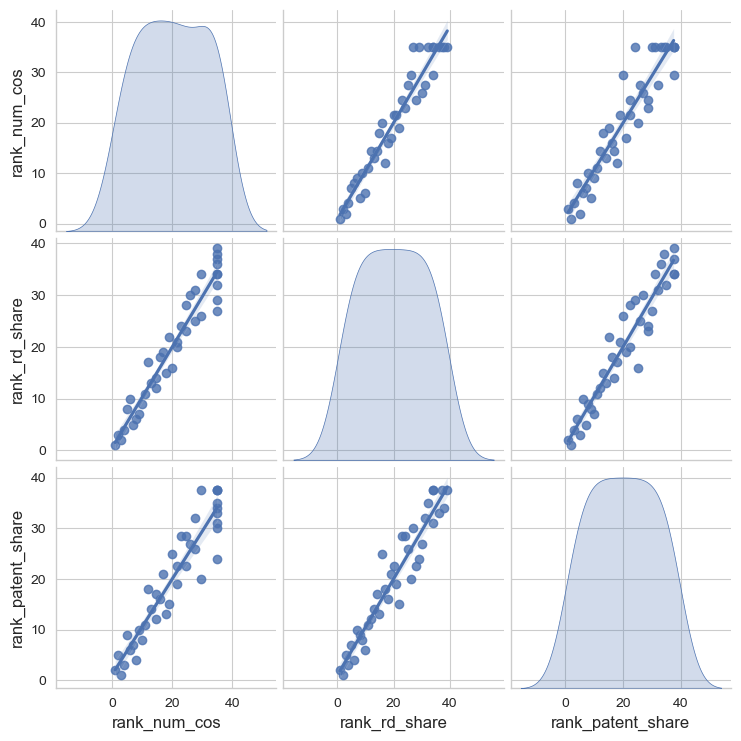

In [235]:
# Build DataFrame with variables we want to see correlations for
df = pd.DataFrame().assign(hq_country = country_analysis['hq_country'],
                           rank_num_cos = country_analysis['rank_num_cos'],
                           rank_rd_share = country_analysis['rank_rd_share'],
                           rank_patent_share = country_analysis['rank_patent_share'])

# Pairplot data
sns.set_palette("deep")
sns.pairplot(df, kind='reg', diag_kind='kde')

# Show graph
plt.show()





### Question: Which countries host the greatest number of Top 2,000 R&D Companies?

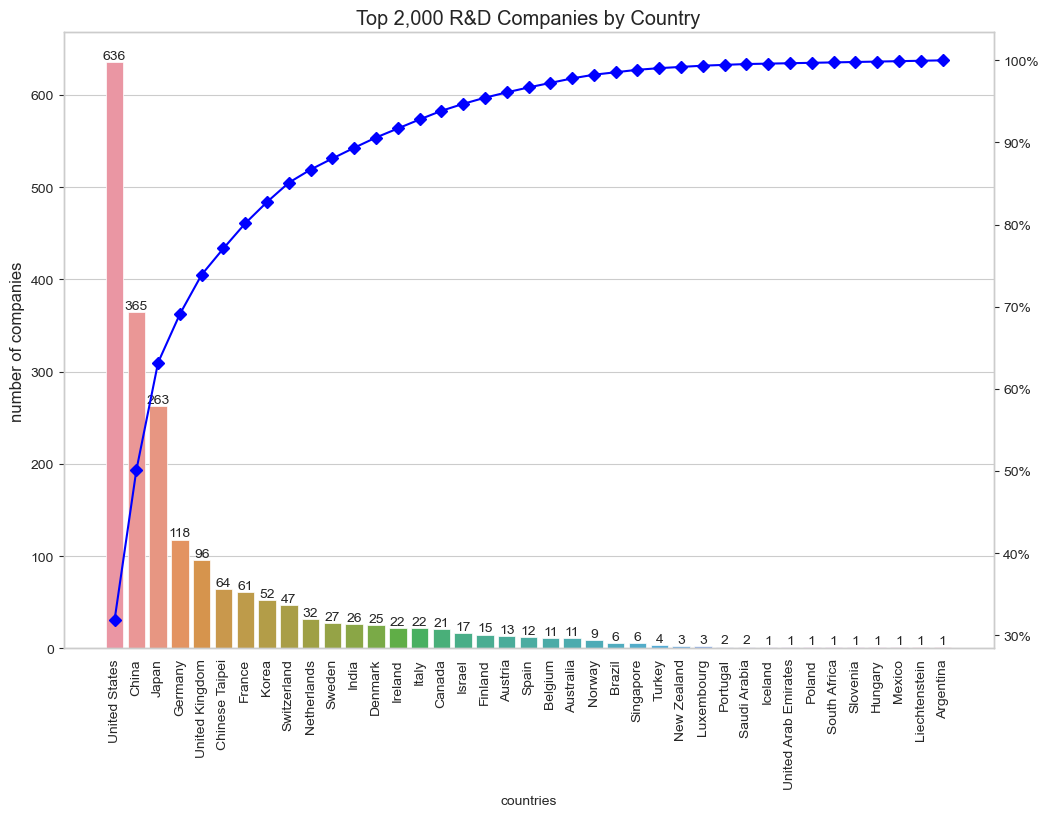

In [247]:
# Barplot

# Reorder by number of companies
ordered_df = country_analysis.sort_values(by='num_cos', ascending = False)

# Calculate cumulative percentage
ordered_df['cume_per'] = ordered_df['num_cos'].cumsum()/ordered_df['num_cos'].sum()*100

# Setup plot
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")

# Plot number of companies on Axis 1
ax = sns.barplot(y = 'num_cos',
            x = 'hq_country',
            data = ordered_df,
            orient = 'v')
ax.bar_label(ax.containers[0], fontsize=10)

# Title and axes
plt.title('Top 2,000 R&D Companies by Country')
plt.ylabel('number of companies')
plt.xlabel('countries', fontsize=10)
plt.xticks(rotation = 'vertical')

# Plot cume % of companies on Axis 2
ax2 = ax.twinx()
ax2.plot(ordered_df['hq_country'], ordered_df['cume_per'], color='blue', marker="D", ms=6)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

# Show graph
plt.show()

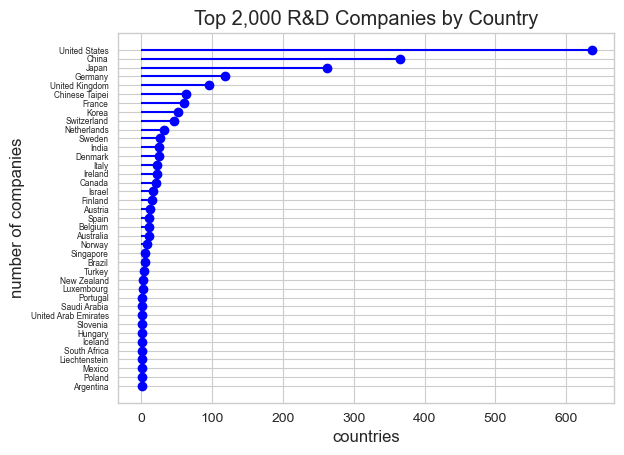

In [158]:
# Lollipop plot

# Reorder by number of companies
ordered_df = country_analysis.sort_values(by='num_cos', ascending = True)
my_range = range(1,len(country_analysis.index)+1)

# Plot data
plt.hlines(y = my_range, xmin = 0, xmax = ordered_df['num_cos'], color = 'blue')
plt.plot(ordered_df['num_cos'], my_range, "o", color = 'blue')

# Add text
plt.yticks(my_range, ordered_df['hq_country'], fontsize=6)
plt.title('Top 2,000 R&D Companies by Country')
plt.xlabel('countries')
plt.ylabel('number of companies')

# Show graph
plt.show()

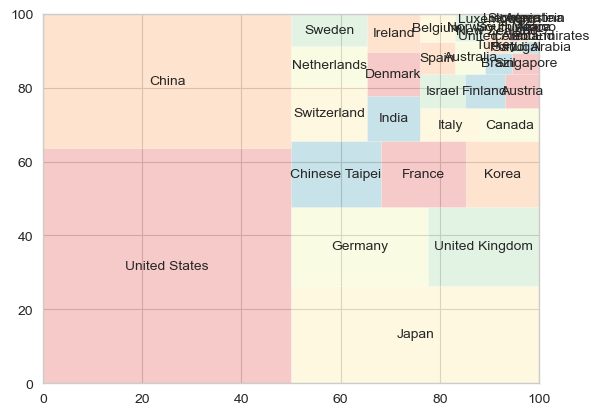

In [159]:
# Treemap

# Reorder by number of companies
ordered_df = country_analysis.sort_values(by='num_cos', ascending = False)

# Plot data
squarify.plot(sizes = ordered_df['num_cos'],
              label = ordered_df['hq_country'],
              color = sns.color_palette("Spectral"),
              alpha=.3)

# Show graph
plt.show()

### Question: Which countries have the highest R&D expenditure share within the sample?

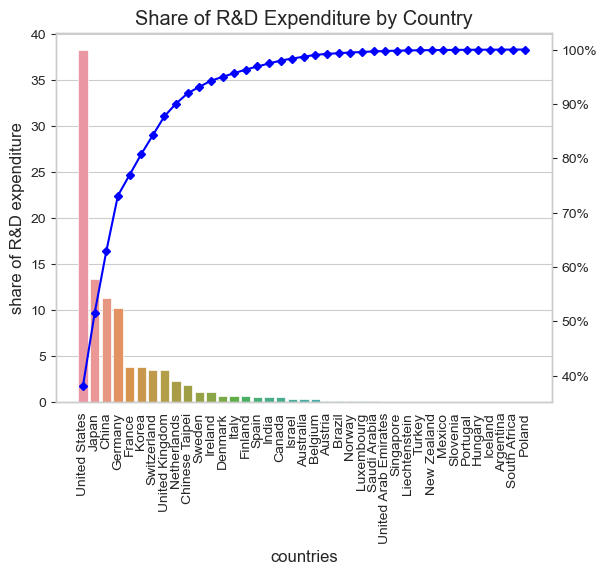

In [160]:
# Barplot

# Reorder by R&D share
ordered_df = country_analysis.sort_values(by='rd_share', ascending = False)

# Calculate cumulative percentage
ordered_df['cume_per'] = ordered_df['rd_share'].cumsum()/ordered_df['rd_share'].sum()*100


# Plot number of companies on Axis 1
sns.set_style("whitegrid")
ax = sns.barplot(y = 'rd_share',
            x = 'hq_country',
            data = ordered_df,
            orient = 'v')
plt.title('Share of R&D Expenditure by Country')
plt.ylabel('share of R&D expenditure')
plt.xlabel('countries')
plt.xticks(rotation = 'vertical')

# Plot cume % of companies on Axis 2
ax2 = ax.twinx()
ax2.plot(ordered_df['hq_country'], ordered_df['cume_per'], color='blue', marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

# Show graph
plt.show()

### Question: Which countries have the highest patent share within the sample?

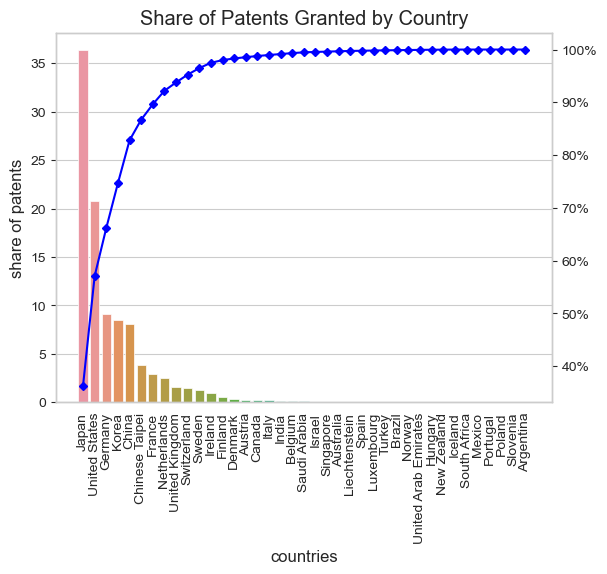

In [161]:
# Barplot

# Reorder by patent share
ordered_df = country_analysis.sort_values(by='patent_share', ascending = False)

# Calculate cumulative percentage
ordered_df['cume_per'] = ordered_df['patent_share'].cumsum()/ordered_df['patent_share'].sum()*100


# Plot number of companies on Axis 1
sns.set_style("whitegrid")
ax = sns.barplot(y = 'patent_share',
            x = 'hq_country',
            data = ordered_df,
            orient = 'v')
plt.title('Share of Patents Filed by Country')
plt.ylabel('Share of Patents')
plt.xlabel('Countries')
plt.xticks(rotation = 'vertical')

# Plot cume % of companies on Axis 2
ax2 = ax.twinx()
ax2.plot(ordered_df['hq_country'], ordered_df['cume_per'], color='blue', marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

# Show graph
plt.show()

### Question: How do these answers change if we normalize by population i.e. use per capita figures?

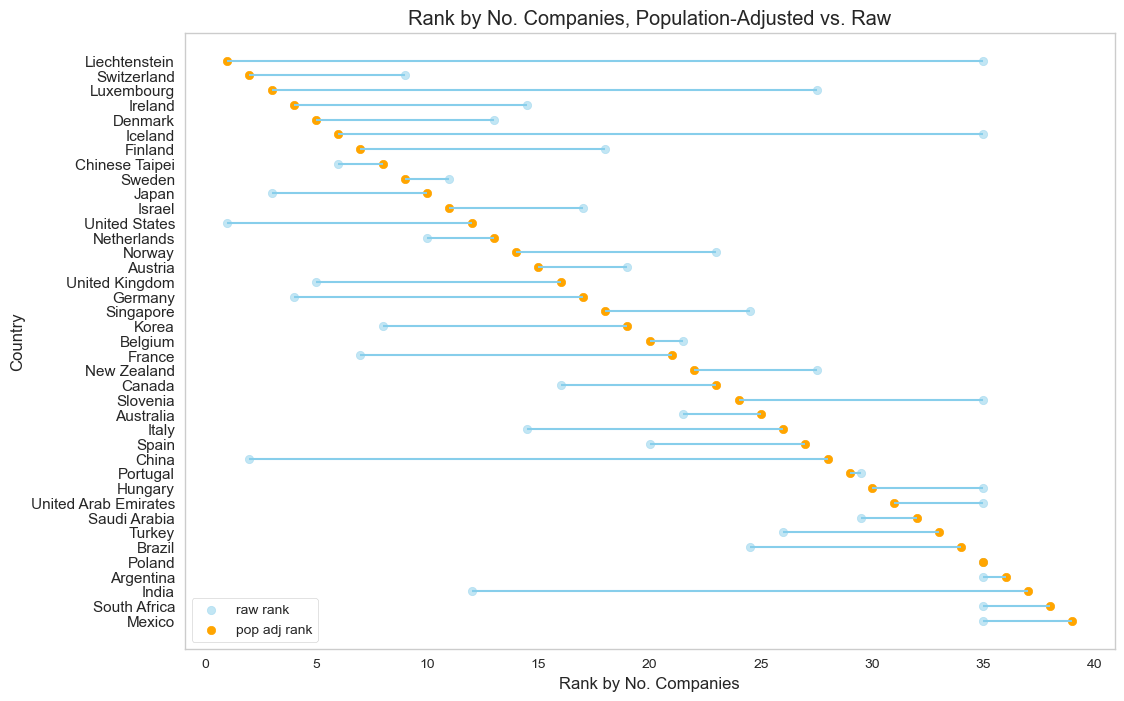

In [249]:
# Rank by Number of Companies - Lollipop chart with 2 observation series

# Create a new dataframe to compare raw ranks and pop adj ranks
value1 = country_analysis['rank_num_cos']
value2 = country_analysis['rank_num_co_pop']
df = pd.DataFrame({'country':country_analysis['hq_country'], 'raw rank':value1, 'pop adj rank':value2})

# Reorder based on the pop adj rank
ordered_df = df.sort_values(by='pop adj rank', ascending = False)
my_range = range(1, len(df.index)+1)

# Plot the data
plt.figure(figsize=(12,8))
plt.hlines(y = my_range, xmin = ordered_df['pop adj rank'], xmax = ordered_df['raw rank'], color='skyblue', alpha = 1)
plt.scatter(ordered_df['raw rank'], my_range, color='skyblue', alpha=.5, label='raw rank')
plt.scatter(ordered_df['pop adj rank'], my_range, color='orange', alpha=1, label='pop adj rank')
plt.grid(False)
plt.legend()

# Add title and axis data
plt.yticks(my_range, ordered_df['country'], fontsize = 11)
plt.title("Rank by No. Companies, Population-Adjusted vs. Raw")
plt.xlabel("Rank by No. Companies")
plt.ylabel("Country")

# Show graph
plt.show()


### Question: What's the reason for Liechtenstein's ranking?

In [258]:
# Query to see backup behind num_co_per_mcapita calculation
country_analysis.query('hq_country == "Liechtenstein"')

,hq_country,num_cos,rd_share,patent_share,pop,pop_share,num_co_per_mcapita,rd_share_to_pop_share,patent_share_to_pop_share,patent_eff,rank_num_cos,rank_rd_share,rank_patent_share,rank_pop_share,rank_num_co_pop,rank_rd_pop,rank_patent_pop,rank_patent_eff
20,Liechtenstein,1,0.039,0.06,38128,0.000009,26.227444,4574.918598,7038.336304,1.538462,35.0,29.0,24.0,39.0,1.0,1.0,1.0,5.0


In [259]:
# What companies are HQ'd in Liechtenstein?
ip.query('hq_country == "Liechtenstein"')

,rank,company,hq_country,industry,rd_share,patent_share,trademark_share,patent_eff,rank_rd_share,rank_patent_share,rank_patent_eff
407,408,HILTI,Liechtenstein,Machinery,0.039,0.06,0.002,1.538462,409.0,300.5,431.0


In [250]:
ordered_df

,country,raw rank,pop adj rank
22,Mexico,35.0,39.0
31,South Africa,35.0,38.0
14,India,12.0,37.0
0,Argentina,35.0,36.0
26,Poland,35.0,35.0
4,Brazil,24.5,34.0
35,Turkey,26.0,33.0
28,Saudi Arabia,29.5,32.0
36,United Arab Emirates,35.0,31.0
12,Hungary,35.0,30.0


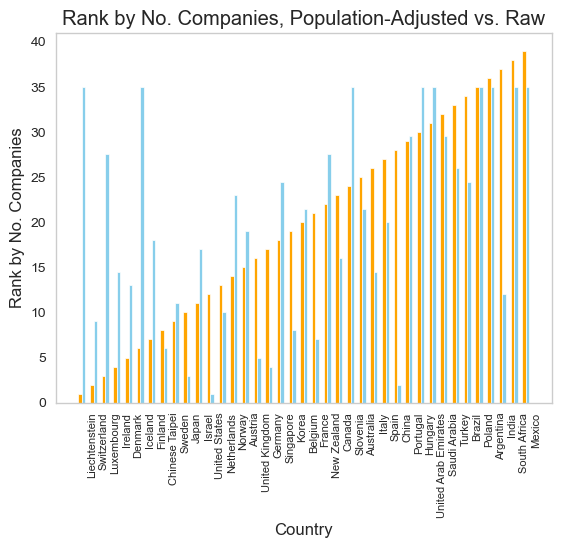

In [163]:
# Barplot with 2 observation series

# Create a new dataframe to compare raw ranks and pop adj ranks
value1 = country_analysis['rank_num_co_pop']
value2 = country_analysis['rank_num_cos']
df = pd.DataFrame({'country':country_analysis['hq_country'], 'pop adj rank':value1, 'raw rank':value2})

# Reorder based on the pop adj rank
ordered_df = df.sort_values(by='pop adj rank', ascending = True)
my_range = range(1, len(df.index)+1)

# Create bars
barWidth = 0.3
bars1 = ordered_df['pop adj rank']
bars2 = ordered_df['raw rank']

# x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create raw bars
plt.bar(r1, bars1, width = barWidth, color = 'orange')
plt.bar(r2, bars2, width = barWidth, color = 'skyblue')

# Add title and axis data
plt.xticks(my_range, ordered_df['country'], rotation = 90, fontsize = 8)
plt.title("Rank by No. Companies, Population-Adjusted vs. Raw")
plt.xlabel("Country")
plt.ylabel("Rank by No. Companies")
plt.grid(False)

# Show graph
plt.show()



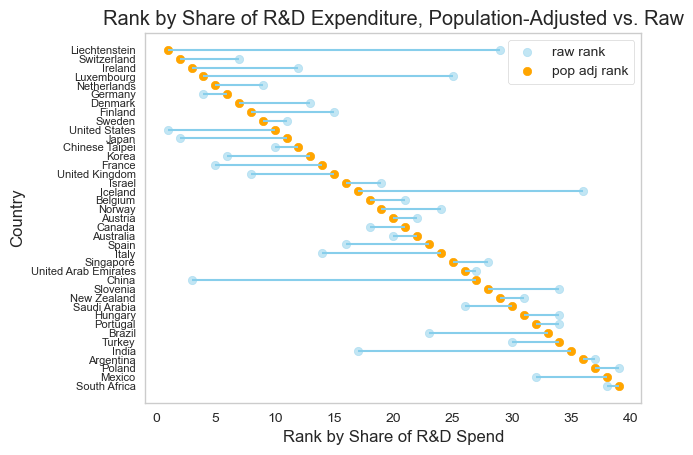

In [164]:
# Rank by R&D Expenditure Share - Lollipop chart with 2 observation series

# Create a new dataframe to compare raw ranks and pop adj ranks
value1 = country_analysis['rank_rd_share']
value2 = country_analysis['rank_rd_pop']
df = pd.DataFrame({'country':country_analysis['hq_country'], 'raw rank':value1, 'pop adj rank':value2})

# Reorder based on the pop adj rank
ordered_df = df.sort_values(by='pop adj rank', ascending = False)
my_range = range(1, len(df.index)+1)

# Plot the data
plt.hlines(y = my_range, xmin = ordered_df['pop adj rank'], xmax = ordered_df['raw rank'], color='skyblue', alpha = 1)
plt.scatter(ordered_df['raw rank'], my_range, color='skyblue', alpha=.5, label='raw rank')
plt.scatter(ordered_df['pop adj rank'], my_range, color='orange', alpha=1, label='pop adj rank')
plt.grid(False)
plt.legend()

# Add title and axis data
plt.yticks(my_range, ordered_df['country'], fontsize = 8)
plt.title("Rank by Share of R&D Expenditure, Population-Adjusted vs. Raw")
plt.xlabel("Rank by Share of R&D Spend")
plt.ylabel("Country")

# Show graph
plt.show()

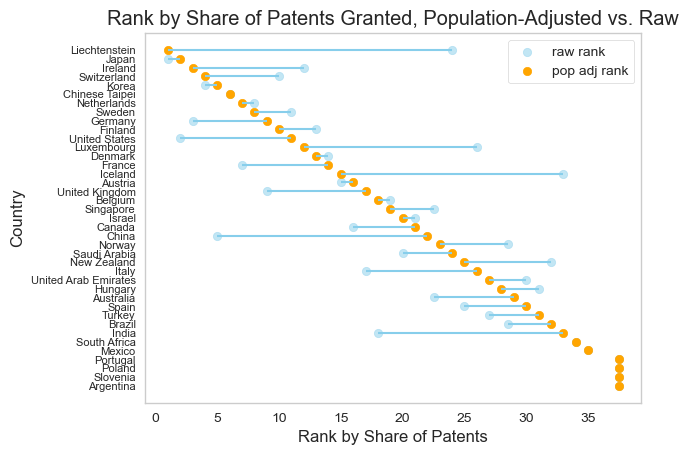

In [165]:
# Rank by Patent Share - Lollipop chart with 2 observation series

# Create a new dataframe to compare raw ranks and pop adj ranks
value1 = country_analysis['rank_patent_share']
value2 = country_analysis['rank_patent_pop']
df = pd.DataFrame({'country':country_analysis['hq_country'], 'raw rank':value1, 'pop adj rank':value2})

# Reorder based on the pop adj rank
ordered_df = df.sort_values(by='pop adj rank', ascending = False)
my_range = range(1, len(df.index)+1)

# Plot the data
plt.hlines(y = my_range, xmin = ordered_df['pop adj rank'], xmax = ordered_df['raw rank'], color='skyblue', alpha = 1)
plt.scatter(ordered_df['raw rank'], my_range, color='skyblue', alpha=.5, label='raw rank')
plt.scatter(ordered_df['pop adj rank'], my_range, color='orange', alpha=1, label='pop adj rank')
plt.grid(False)
plt.legend()

# Add title and axis data
plt.yticks(my_range, ordered_df['country'], fontsize = 8)
plt.title("Rank by Share of Patents Filed, Population-Adjusted vs. Raw")
plt.xlabel("Rank by Share of Patents")
plt.ylabel("Country")

# Show graph
plt.show()

### Question: Are the per cap results potentially explained by favorable taxation?

In [266]:
# Create list of favorable tax jurisdictions from https://en.wikipedia.org/wiki/Tax_haven#Top_10_tax_havens
fav_tax_jur = ['Bahamas',
               'Bermuda',
               'British Virgin Islands',
               'Cayman Islands',
               'Ireland',
               'Hong Kong',
               'Jersey',
               'Luxembourg',
               'Netherlands',
               'Puerto Rico',
               'Singapore',
               'Switzerland']

# Create a new dataframe to find companies located in favorable tax jurisdictions
df = pd.DataFrame().assign(company = ip['company'],
                           country = ip['hq_country'])
df['fav_tax'] = df['country'].isin(fav_tax_jur)
fav_tax_cos = df.loc[df['fav_tax'] == True]
fav_tax_cos = fav_tax_cos.sort_values(by='company', ascending = True)

# Show the companies, sorted alphabetically
print(fav_tax_cos)


                                company      country  fav_tax
136                                 ABB  Switzerland     True
215                           ACCENTURE      Ireland     True
617                              ADIENT      Ireland     True
604                               AHOLD  Netherlands     True
47                               AIRBUS  Netherlands     True
...                                 ...          ...      ...
898           WEATHERFORD INTERNATIONAL      Ireland     True
1727                     WRIGHT MEDICAL  Netherlands     True
439                              YANDEX  Netherlands     True
1664                            YPSOMED  Switzerland     True
1019  ZUIVELCOOPERATIE FRIESLANDCAMPINA  Netherlands     True

[110 rows x 3 columns]


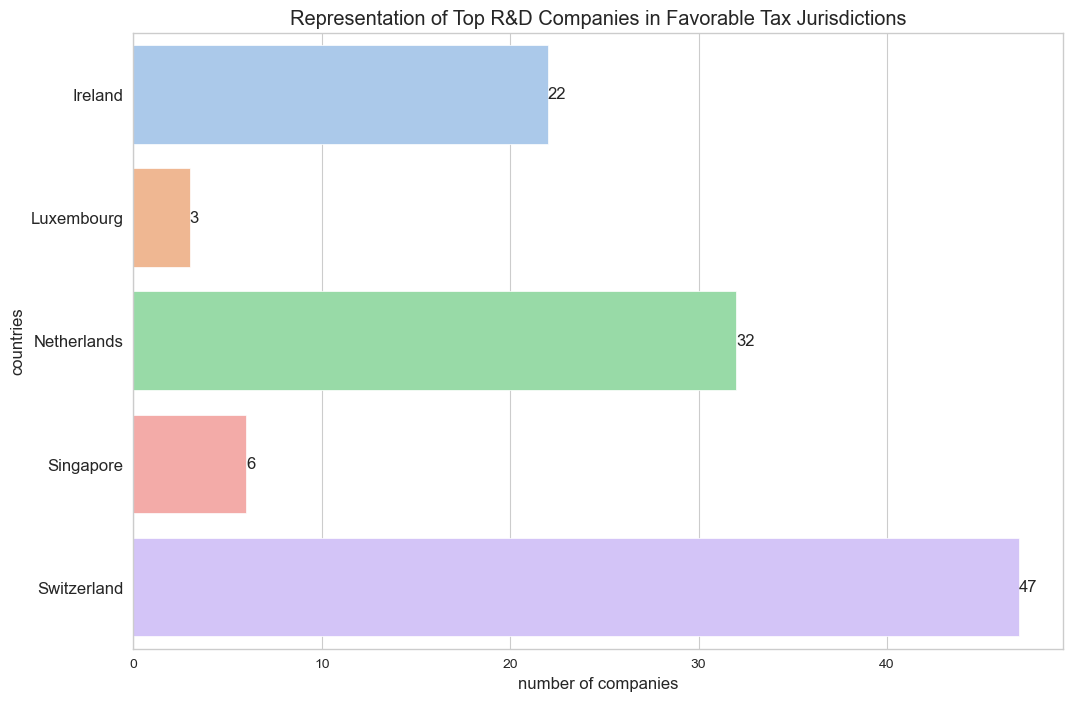

In [268]:
# Group the dataframe by country
df = fav_tax_cos.groupby("country").count()
df = pd.DataFrame(df.to_records())

# Barplot number of companies
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
ax = sns.barplot(x = 'company',
                 y = 'country',
                 data = df,
                 orient = 'h',
                 palette = 'pastel')
ax.bar_label(ax.containers[0], fontsize=12)
plt.title('Representation of Top R&D Companies in Favorable Tax Jurisdictions')
plt.xlabel('number of companies')
plt.ylabel('countries')
plt.yticks(fontsize = 12)

# Show graph
plt.show()

### Question: Which countries produce the greatest share of patents per dollar expenditure in the sample?

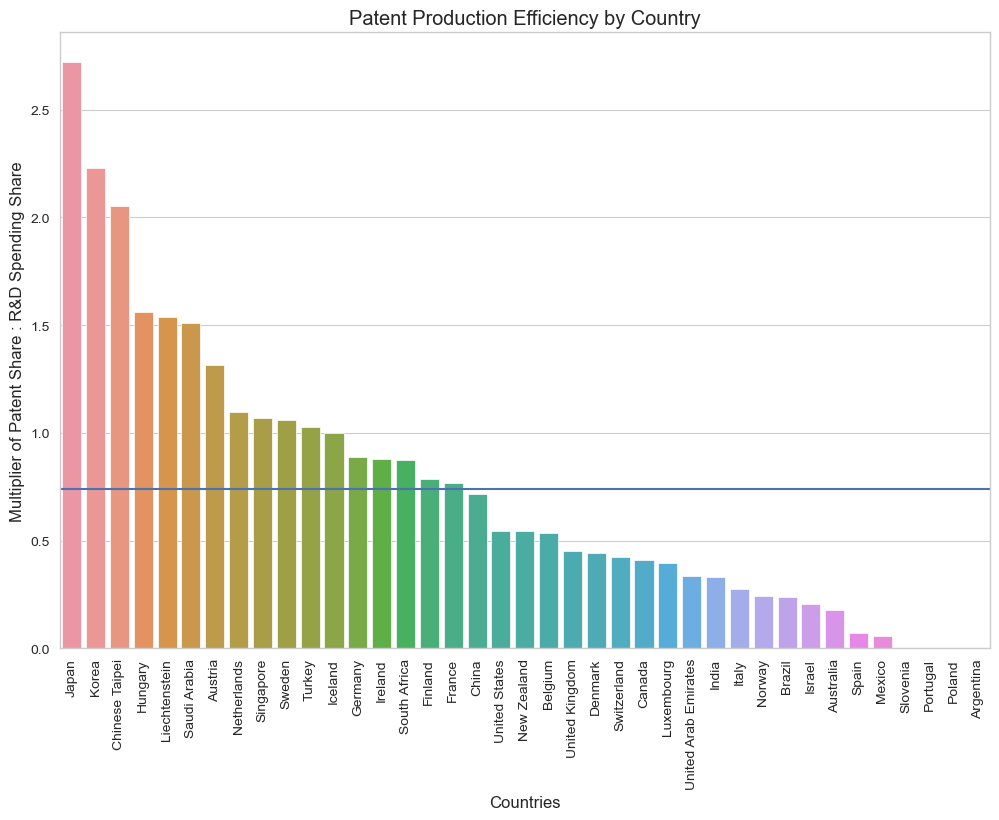

In [275]:
# Barplot of Patent Efficiency Metric
plt.figure(figsize=(12,8))
sns.barplot(x = 'hq_country',
            y = 'patent_eff',
            data = country_analysis,
            order = country_analysis.sort_values('patent_eff', ascending = False).hq_country)

# Axes and Labels
plt.xticks(rotation=90, fontsize = 10)
plt.title('Patent Production Efficiency by Country')
plt.xlabel('Countries')
plt.ylabel('Multiplier of Patent Share : R&D Spending Share')

# Draw a line at the average multiplier value
plt.axhline(y = country_analysis['patent_eff'].mean())

# Show graph
plt.show()


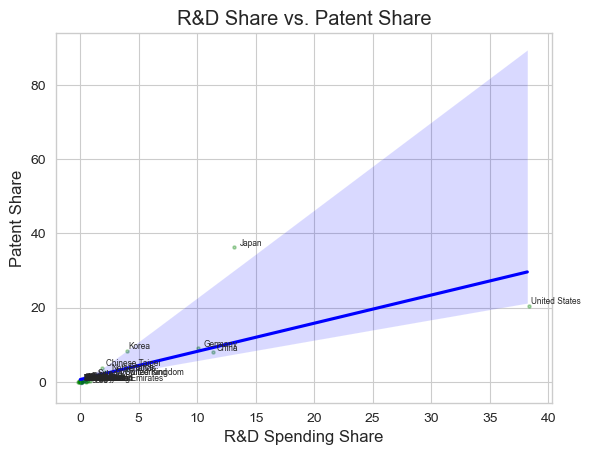

In [197]:
# Scatterplot with Linear Regression

# Draw scatterplot
df = country_analysis

sns.set_style('whitegrid')

sns.regplot(x = 'rd_share', 
            y = 'patent_share',
            data = df,
            x_jitter = 0.2,
            y_jitter = 0.2,
            scatter_kws = {"color":"green", "alpha":0.3, "s":5},
            line_kws = {"color":"b"},
           )

# Axes and Labels
plt.title('R&D Share vs. Patent Share')
plt.xlabel('R&D Spending Share')
plt.ylabel('Patent Share')

# Add labels
for i in range(df.shape[0]):
    plt.text(x = df.rd_share[i]+0.3, y = df.patent_share[i]+0.3, s=df.hq_country[i],
    fontdict = dict(size = 6))

# Show graph
plt.show()


# Analysis B:  Industry Analysis

### Set Up Industry Analysis DataFrame

In [178]:
# Set up data grouped by industry
industry_group = ip.groupby("industry")

# Apply aggregates (Part a-c)
colFun = {'industry':['count'],
          'rd_share':['sum'],
          'patent_share':['sum']}

industry_analysis = industry_group.agg(colFun)

# Rename columns
industry_analysis = pd.DataFrame(industry_analysis.to_records())  # flatten hierarchical index
industry_analysis.columns = ["industry", "num_cos", "rd_share", "patent_share"]

### Calculations

In [179]:
# Calculate patent efficiency
industry_analysis['patent_eff'] = industry_analysis['patent_share']/industry_analysis['rd_share']


### Rank Metrics

In [181]:
# Add ranks
industry_analysis['rank_num_cos'] = industry_analysis['num_cos'].rank(ascending=False)
industry_analysis['rank_rd_share'] = industry_analysis['rd_share'].rank(ascending=False)
industry_analysis['rank_patent_share'] = industry_analysis['patent_share'].rank(ascending=False)
industry_analysis['rank_patent_eff'] = industry_analysis['patent_eff'].rank(ascending=False)

In [183]:
industry_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   industry           33 non-null     object 
 1   num_cos            33 non-null     int64  
 2   rd_share           33 non-null     float64
 3   patent_share       33 non-null     float64
 4   patent_eff         33 non-null     float64
 5   rank_num_cos       33 non-null     float64
 6   rank_rd_share      33 non-null     float64
 7   rank_patent_share  33 non-null     float64
 8   rank_patent_eff    33 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 2.4+ KB


### Question: How correlated are industry rankings of different measures of R&D activity, e.g. number of companies, R&D spending share, patent share? 

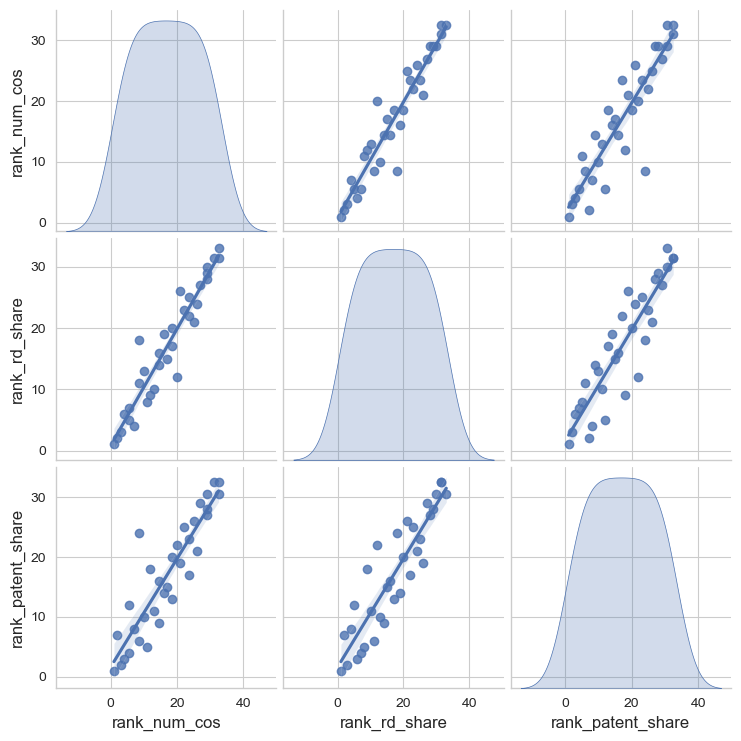

In [282]:
# Build DataFrame with variables we want to see correlations for
df = pd.DataFrame().assign(industry = industry_analysis['industry'],
                           rank_num_cos = industry_analysis['rank_num_cos'],
                           rank_rd_share = industry_analysis['rank_rd_share'],
                           rank_patent_share = industry_analysis['rank_patent_share'])

# Pairplot data
sns.set_palette("deep")
sns.pairplot(df, kind='reg', diag_kind='kde')

# Show graph
plt.show()


### Question: Which industries have the greatest number of Top 2,000 R&D Companies?

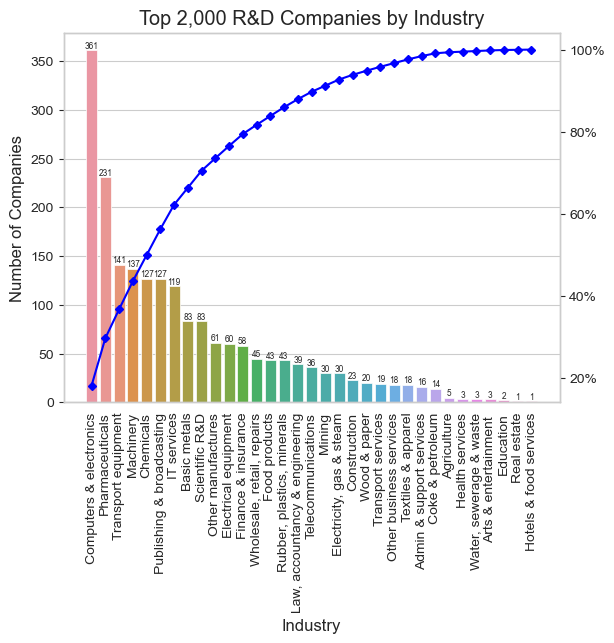

In [185]:
# Barplot

# Reorder by number of companies
ordered_df = industry_analysis.sort_values(by='num_cos', ascending = False)

# Calculate cumulative percentage
ordered_df['cume_per'] = ordered_df['num_cos'].cumsum()/ordered_df['num_cos'].sum()*100

# Plot number of companies on Axis 1
sns.set_style("whitegrid")
ax = sns.barplot(y = 'num_cos',
            x = 'industry',
            data = ordered_df,
            orient = 'v')
ax.bar_label(ax.containers[0], fontsize=6)
plt.title('Top 2,000 R&D Companies by Industry')
plt.ylabel('Number of Companies')
plt.xlabel('Industry')
plt.xticks(rotation = 'vertical')

# Plot cume % of companies on Axis 2
ax2 = ax.twinx()
ax2.plot(ordered_df['industry'], ordered_df['cume_per'], color='blue', marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

# Show graph
plt.show()

### Question: Which industries have the highest R&D expenditure share within the sample?

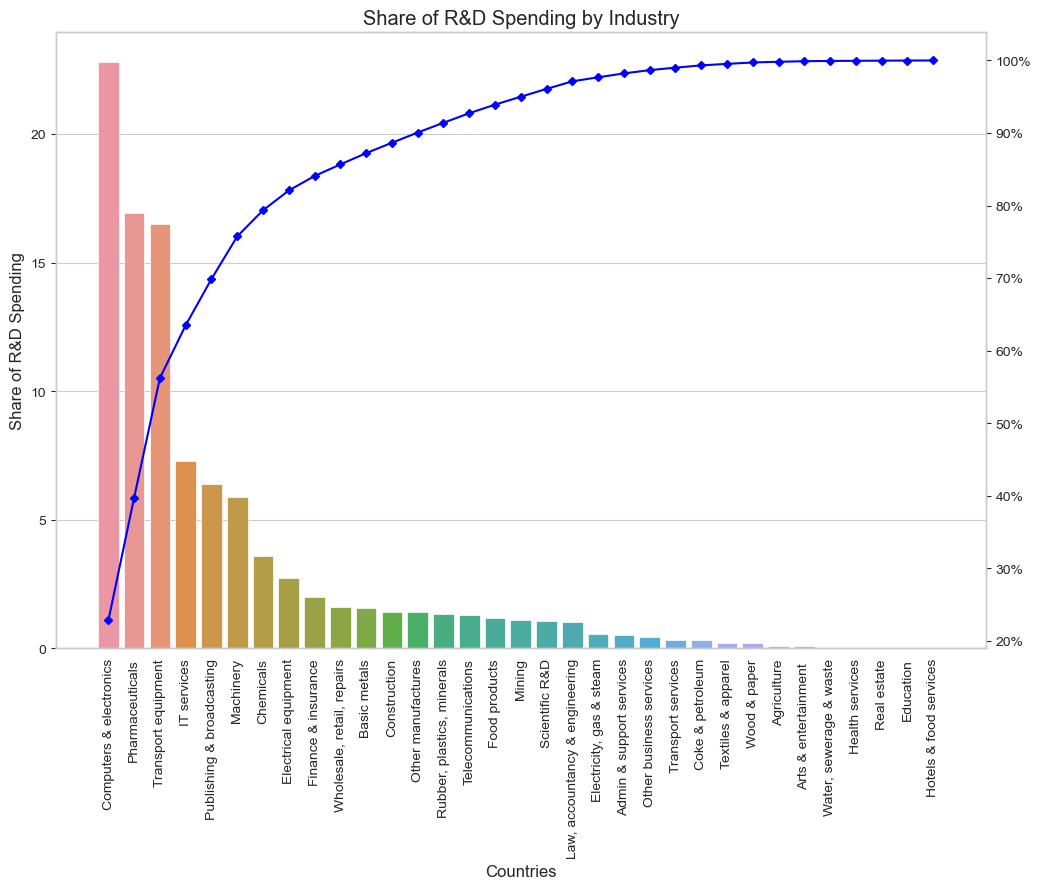

In [280]:
# Barplot

# Reorder by R&D share
ordered_df = industry_analysis.sort_values(by='rd_share', ascending = False)

# Calculate cumulative percentage
ordered_df['cume_per'] = ordered_df['rd_share'].cumsum()/ordered_df['rd_share'].sum()*100

# Plot number of companies on Axis 1
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
ax = sns.barplot(y = 'rd_share',
            x = 'industry',
            data = ordered_df,
            orient = 'v')
plt.title('Share of R&D Spending by Industry')
plt.ylabel('Share of R&D Spending')
plt.xlabel('Countries')
plt.xticks(rotation = 'vertical', fontsize = 10)

# Plot cume % of companies on Axis 2
ax2 = ax.twinx()
ax2.plot(ordered_df['industry'], ordered_df['cume_per'], color='blue', marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

# Show graph
plt.show()

### Question: Which industries have the highest patent share within the sample?

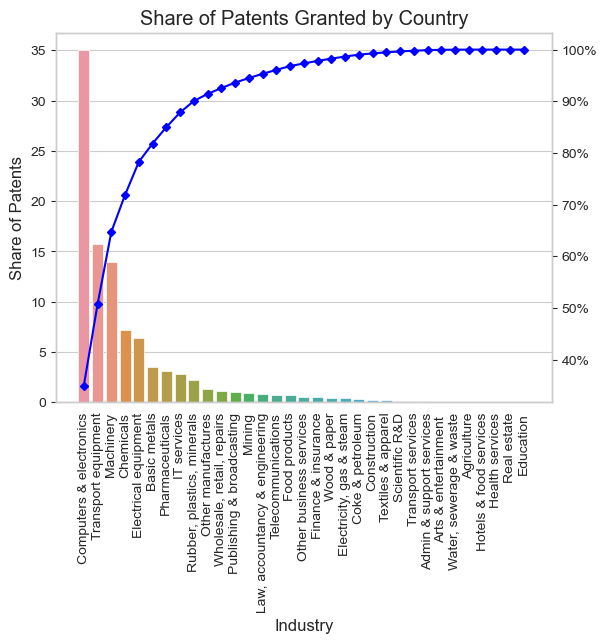

In [190]:
# Barplot

# Reorder by number of companies
ordered_df = industry_analysis.sort_values(by='patent_share', ascending = False)

# Calculate cumulative percentage
ordered_df['cume_per'] = ordered_df['patent_share'].cumsum()/ordered_df['patent_share'].sum()*100

# Plot number of companies on Axis 1
sns.set_style("whitegrid")
ax = sns.barplot(y = 'patent_share',
            x = 'industry',
            data = ordered_df,
            orient = 'v')
plt.title('Share of Patents Granted by Country')
plt.ylabel('Share of Patents')
plt.xlabel('Industry')
plt.xticks(rotation = 'vertical')

# Plot cume % of companies on Axis 2
ax2 = ax.twinx()
ax2.plot(ordered_df['industry'], ordered_df['cume_per'], color='blue', marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

# Show graph
plt.show()

### Question: Which industries produce the greatest share of patents per dollar expenditure in the sample?


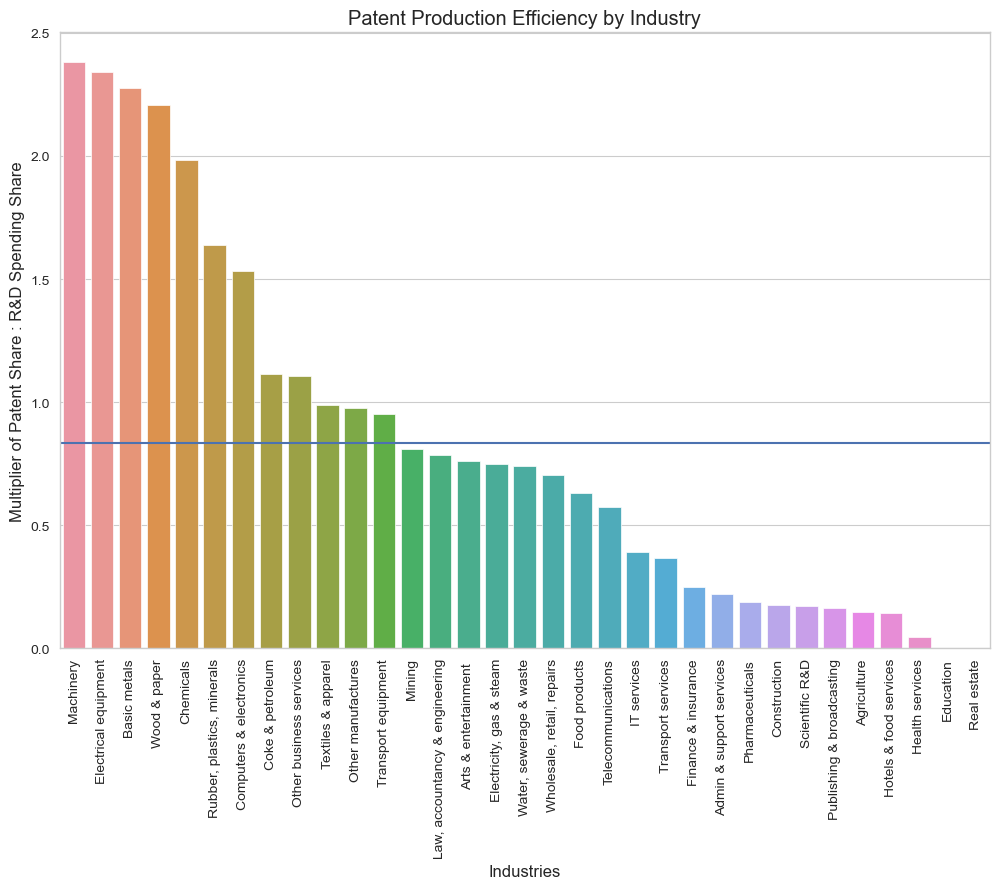

In [290]:
# Barplot of Patent Efficiency Metric
plt.figure(figsize=(12,8))
sns.barplot(x = 'industry',
            y = 'patent_eff',
            data = industry_analysis,
            order = industry_analysis.sort_values('patent_eff', ascending = False).industry)

# Axes and Labels
plt.xticks(rotation=90)
plt.title('Patent Production Efficiency by Industry')
plt.xlabel('Industries')
plt.ylabel('Multiplier of Patent Share : R&D Spending Share')

# Draw a line at the average multiplier value
plt.axhline(y = industry_analysis['patent_eff'].mean())

# Show graph
plt.show()

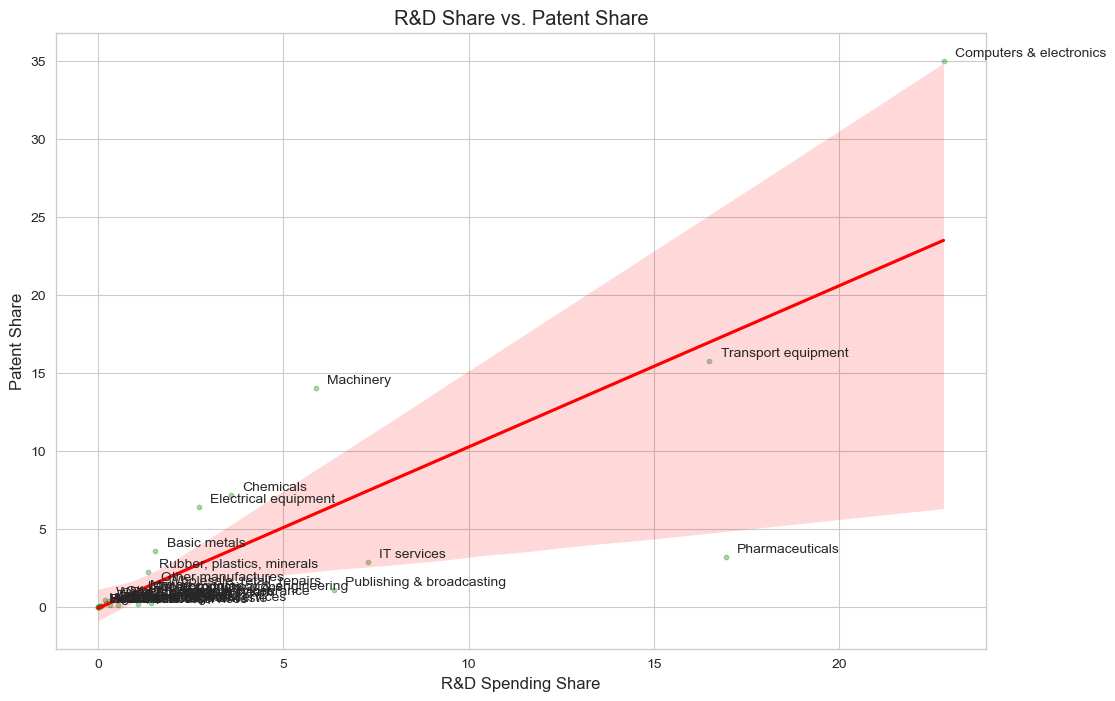

In [287]:
# Scatterplot with Linear Regression

# Draw scatterplot
df = industry_analysis

plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
sns.regplot(x = 'rd_share', 
            y = 'patent_share',
            data = df,
            x_jitter = 0.0,
            y_jitter = 0.0,
            scatter_kws = {"color":"green", "alpha":0.3, "s":10},
            line_kws = {"color":"r"},
           )

# Axes and Labels
plt.title('R&D Share vs. Patent Share')
plt.xlabel('R&D Spending Share')
plt.ylabel('Patent Share')

# Add labels
for i in range(df.shape[0]):
    plt.text(x = df.rd_share[i]+0.3, y = df.patent_share[i]+0.3, s=df.industry[i],
    fontdict = dict(size = 10))

# Show graph
plt.show()


# Analysis C:  Company Analysis

### Set Up Company Analysis DataFrame

In [387]:
# Set up the raw data
company_analysis = ip

### Calculations

In [388]:
# Calculate patent efficiency
company_analysis['patent_eff'] = company_analysis['patent_share']/company_analysis['rd_share']

### Ranking Metrics

In [389]:
# Add ranks
company_analysis['rank_rd_share'] = company_analysis['rd_share'].rank(ascending=False)
company_analysis['rank_patent_share'] = company_analysis['patent_share'].rank(ascending=False)
company_analysis['rank_patent_eff'] = company_analysis['patent_eff'].rank(ascending=False)


In [390]:
company_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               2000 non-null   int64  
 1   company            2000 non-null   object 
 2   hq_country         2000 non-null   object 
 3   industry           2000 non-null   object 
 4   rd_share           2000 non-null   float64
 5   patent_share       2000 non-null   float64
 6   trademark_share    2000 non-null   float64
 7   patent_eff         2000 non-null   float64
 8   rank_rd_share      2000 non-null   float64
 9   rank_patent_share  2000 non-null   float64
 10  rank_patent_eff    2000 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 172.0+ KB


### Question: Which companies have the highest patent share in the sample?

In [396]:
# Sort and rank by patent share
ordered_df = company_analysis.sort_values("rank_patent_share",ascending = True).head(50)
ordered_df.set_index('rank_patent_share', inplace = True)

# Create abbreviated name for shorter xticks
ordered_df['abbrev'] = ordered_df['company'].str[:11]

ordered_df.head(50)

,rank,company,hq_country,industry,rd_share,patent_share,trademark_share,patent_eff,rank_rd_share,rank_patent_eff,abbrev
rank_patent_share,,,,,,,,,,,
1.0,2,SAMSUNG ELECTRONICS,Korea,Computers & electronics,1.842,3.634,1.157,1.972856,2.0,334.0,SAMSUNG ELE
2.0,59,CANON,Japan,Machinery,0.309,2.496,0.137,8.077670,59.0,42.0,CANON
3.0,5,HUAWEI INVESTEMENT & HOLDING CO,China,Computers & electronics,1.582,1.703,0.801,1.076485,5.0,560.0,HUAWEI INVE
4.0,187,BOE TECHNOLOGY GROUP,China,Computers & electronics,0.104,1.608,0.018,15.461538,187.0,13.0,BOE TECHNOL
5.0,15,FORD MOTOR,United States,Transport equipment,0.890,1.544,0.126,1.734831,15.0,379.0,FORD MOTOR
6.0,20,ROBERT BOSCH,Germany,Machinery,0.769,1.518,0.377,1.973992,20.0,333.0,ROBERT BOSC
7.0,32,PANASONIC,Japan,Electrical equipment,0.529,1.441,0.813,2.724008,32.0,227.0,PANASONIC
8.0,65,UNITED TECHNOLOGIES,United States,Transport equipment,0.267,1.373,0.135,5.142322,65.0,89.0,UNITED TECH
9.0,152,SUMITOMO ELECTRIC,Japan,Basic metals,0.127,1.361,0.116,10.716535,152.0,25.0,SUMITOMO EL


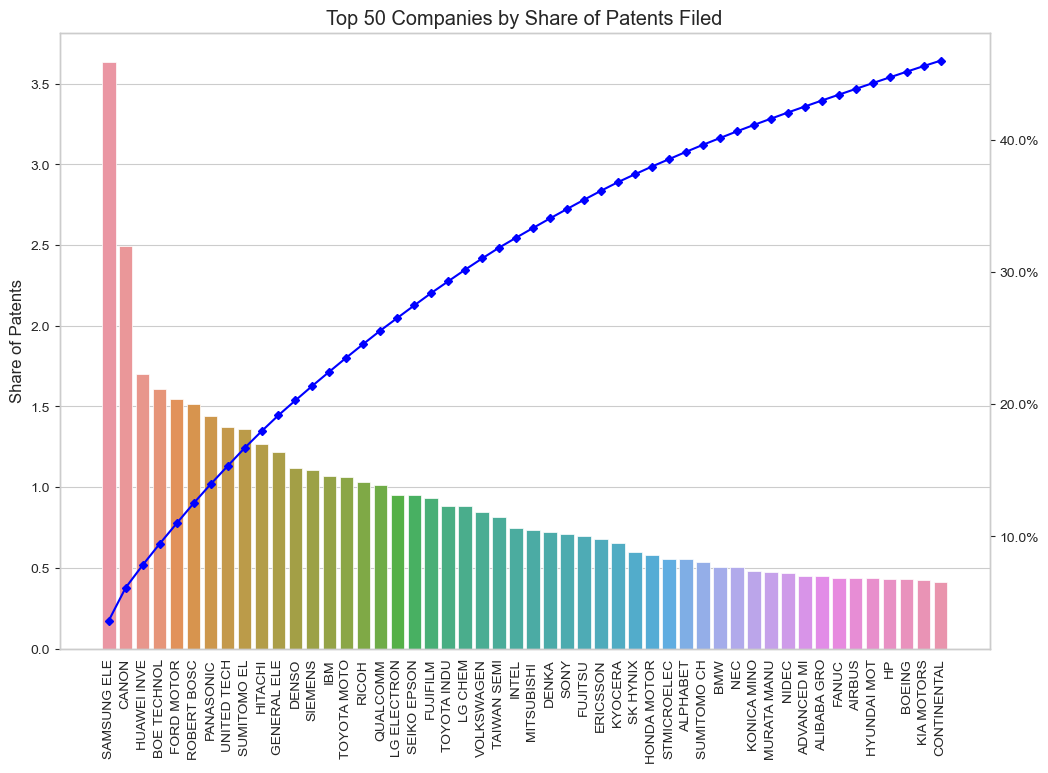

In [397]:
# Barplot

# Calculate cumulative percentage
ordered_df['cume_per'] = ordered_df['patent_share'].cumsum()/company_analysis['patent_share'].sum()*100

# Plot number of companies on Axis 1
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
ax = sns.barplot(y = 'patent_share',
            x = 'abbrev',
            data = ordered_df,
            orient = 'v')
plt.title('Top 50 Companies by Share of Patents Filed')
plt.ylabel('Share of Patents')
plt.xlabel('')
plt.xticks(rotation = 'vertical', fontsize = 10)

# Plot cume % of companies on Axis 2
ax2 = ax.twinx()
ax2.plot(ordered_df['abbrev'], ordered_df['cume_per'], color='blue', marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

# Show graph
plt.show()

### Question: How skewed is the country data from outliers, e.g. Samsung, Canon?

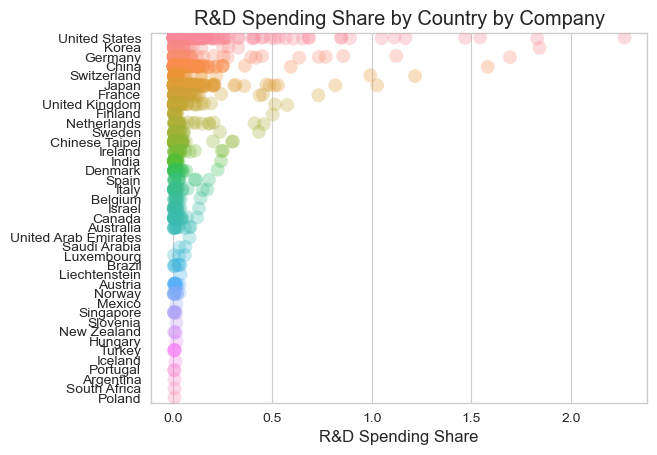

In [411]:
# Stripplot of R&D Spending

# Set DataFrame
df = ip

# Plot Data
ax = sns.stripplot(y = df['hq_country'], x = df['rd_share'], alpha=0.3, size = 10)

# Axes and Labels
plt.title('R&D Spending Share by Country by Company')
plt.xlabel('R&D Spending Share')
plt.ylabel('')

# Show graph
plt.show()

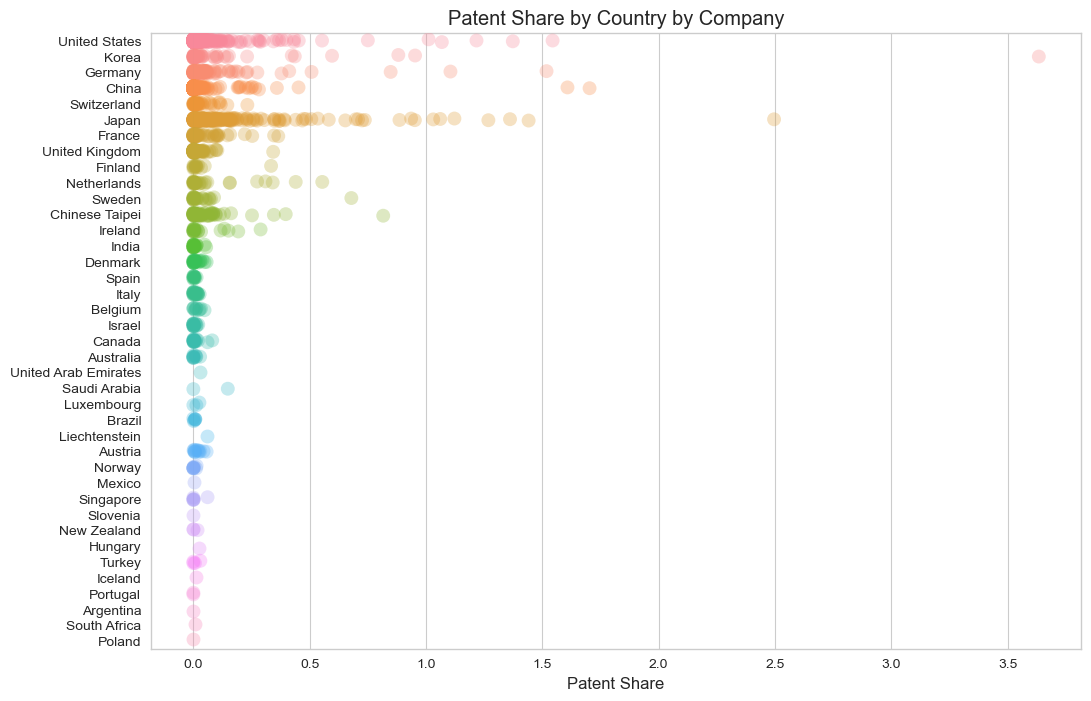

In [413]:
# Stripplot of Patent Share

# Set DataFrame
df = ip

# Plot Data
plt.figure(figsize=(12,8))
ax = sns.stripplot(y = df['hq_country'], x = df['patent_share'], alpha=0.3, size = 10)

# Axes and Labels
plt.title('Patent Share by Country by Company')
plt.xlabel('Patent Share')
plt.ylabel('')

# Show graph
plt.show()

### Questions: How skewed is the industry data from outliers?

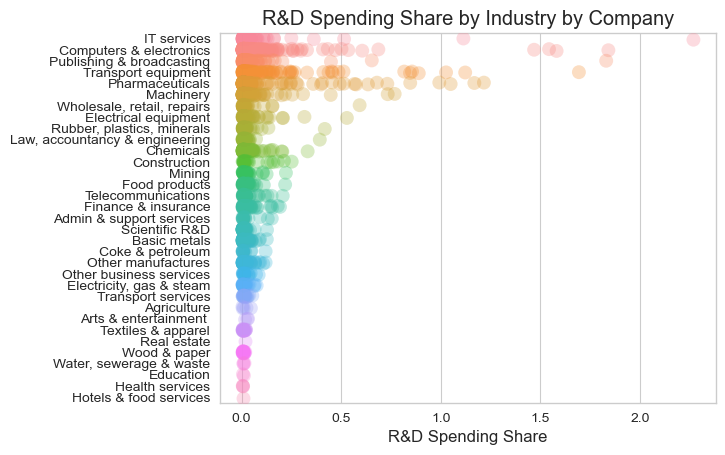

In [422]:
# Stripplot of Patent Share

# Set DataFrame
df = ip

# Plot Data
ax = sns.stripplot(y = df['industry'], x = df['rd_share'], alpha=0.3, size = 10)

# Axes and Labels
plt.title('R&D Spending Share by Industry by Company')
plt.xlabel('R&D Spending Share')
plt.ylabel('')

# Show graph
plt.show()

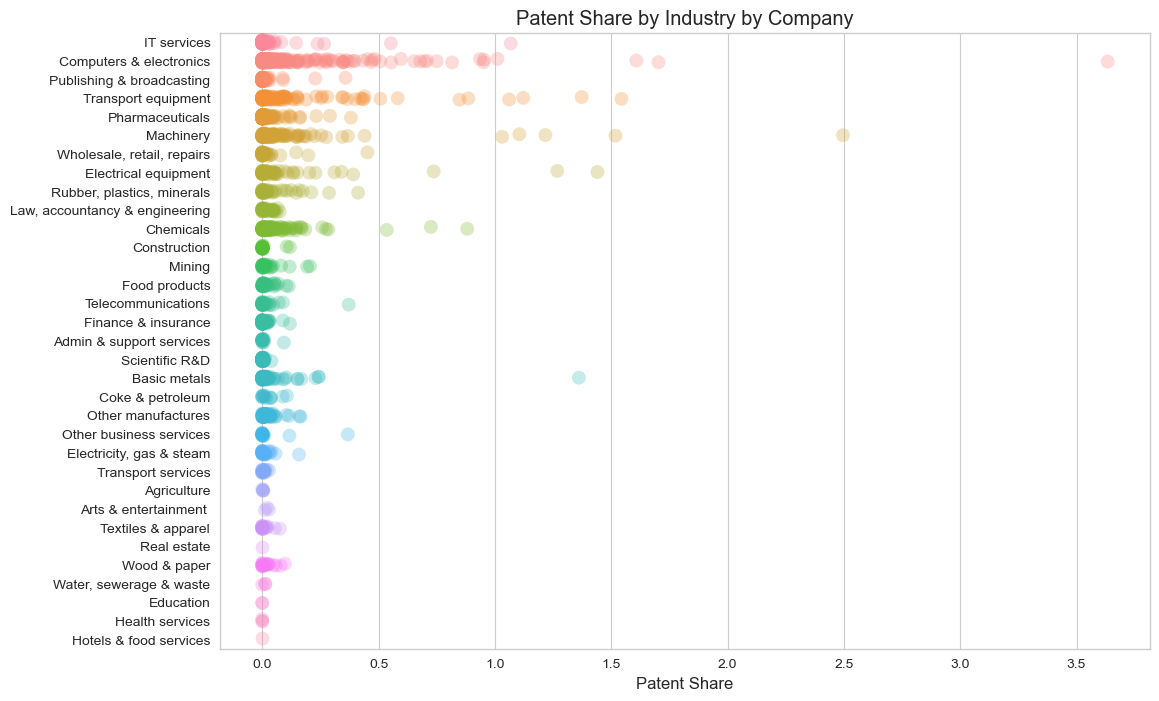

In [418]:
# Stripplot of Patent Share

# Set DataFrame
df = ip

# Plot Data
plt.figure(figsize=(12,8))
ax = sns.stripplot(y = df['industry'], x = df['patent_share'], alpha=0.3, size = 10)

# Axes and Labels
plt.title('Patent Share by Industry by Company')
plt.xlabel('Patent Share')
plt.ylabel('')

# Show graph
plt.show()

### Question: Which companies produce the greatest share of patents per dollar expenditure in the sample?

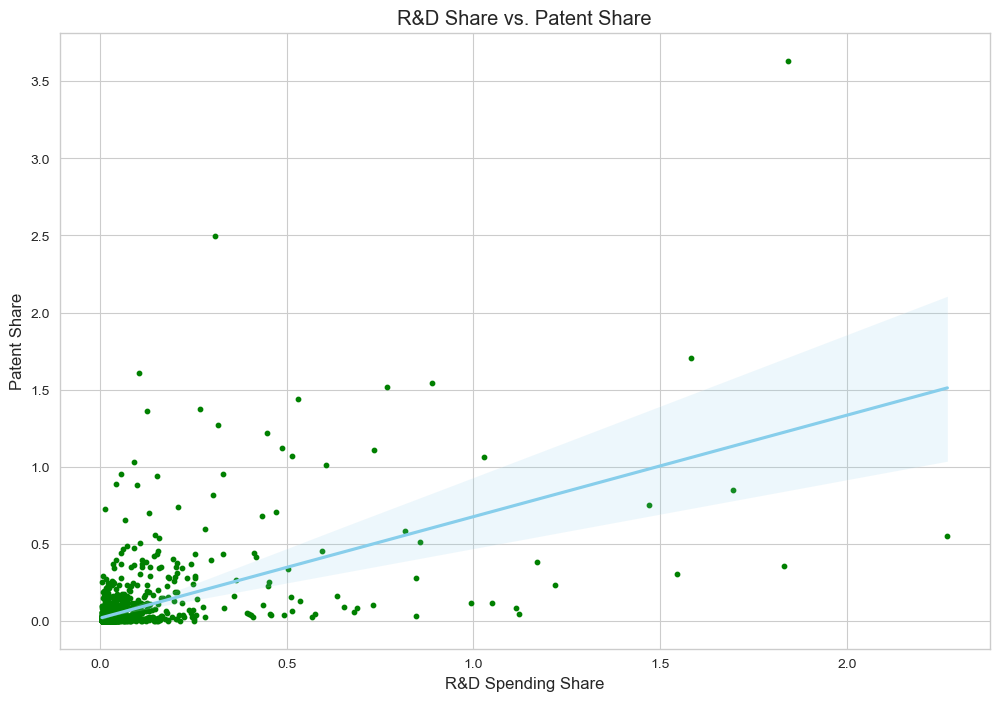

In [436]:
# Scatterplot with Linear Regression

# Draw scatterplot
df = company_analysis

plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
sns.regplot(x = 'rd_share', 
            y = 'patent_share',
            data = df,
            x_jitter = 0.0,
            y_jitter = 0.0,
            scatter_kws = {"color":"green", "alpha":1, "s":10},
            line_kws = {"color":"skyblue"},
           )

# Axes and Labels
plt.title('R&D Share vs. Patent Share')
plt.xlabel('R&D Spending Share')
plt.ylabel('Patent Share')

# Show graph
plt.show()



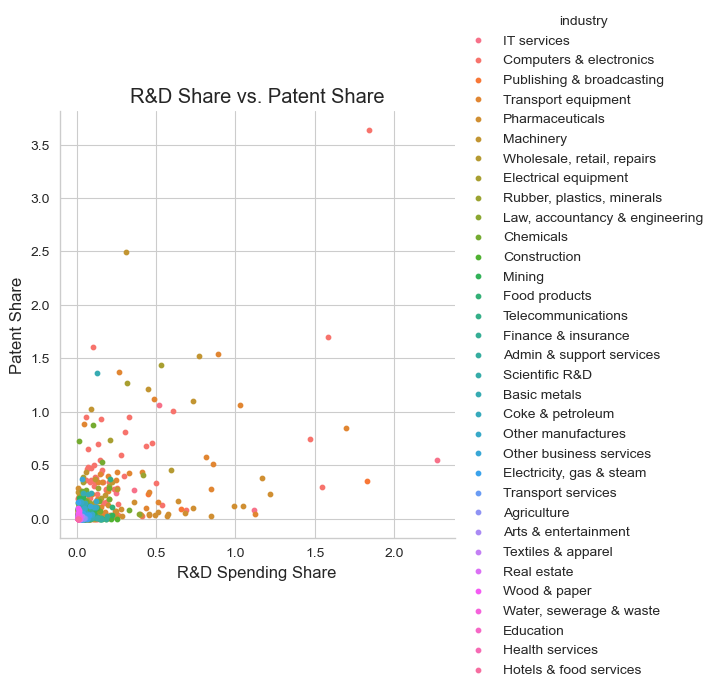

In [338]:
# Scatterplot with Hue

# Draw scatterplot
df = company_analysis

sns.set_style('whitegrid')
sns.lmplot(x = 'rd_share', 
           y = 'patent_share',
           hue = 'industry',
           fit_reg = False,
           data = df,
           x_jitter = 0.0,
           y_jitter = 0.0,
           scatter_kws = {"alpha":1, "s":10}
          )

# Axes and Labels
plt.title('R&D Share vs. Patent Share')
plt.xlabel('R&D Spending Share')
plt.ylabel('Patent Share')

# Show graph
plt.show()

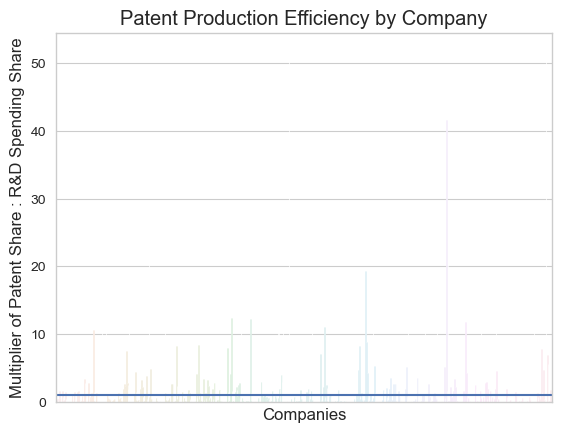

In [339]:
# Barplot of Patent Efficiency Metric
sns.barplot(x = 'company',
            y = 'patent_eff',
            data = company_analysis
           )

# Axes and Labels
plt.xticks(ticks = [])
plt.title('Patent Production Efficiency by Company')
plt.xlabel('Companies')
plt.ylabel('Multiplier of Patent Share : R&D Spending Share')

# Draw a line at the average multiplier value
plt.axhline(y = company_analysis['patent_eff'].mean())

# Show graph
plt.show()



In [398]:
# Top 20 By Patent Efficiency

# Sort and rank by patent share
ordered_df = company_analysis.sort_values("rank_patent_eff",ascending = True).head(50)
ordered_df.set_index('rank_patent_eff')


,rank,company,hq_country,industry,rd_share,patent_share,trademark_share,patent_eff,rank_rd_share,rank_patent_share
rank_patent_eff,,,,,,,,,,
1.0,942,DENKA,Japan,Chemicals,0.014,0.725,0.120,51.785714,955.0,27.0
2.0,1977,SHANGHAI PRIME MACHINERY,China,Machinery,0.005,0.253,0.007,50.600000,1986.0,90.5
3.0,1576,SEIKAGAKU,Japan,Pharmaceuticals,0.007,0.291,0.039,41.571429,1630.0,76.0
4.0,1583,CASIO COMPUTER,Japan,Computers & electronics,0.007,0.189,0.077,27.000000,1630.0,117.0
5.0,376,TOYOTA INDUSTRIES,Japan,Transport equipment,0.043,0.886,0.030,20.604651,374.0,21.0
6.0,1249,TIANMA MICROELECTRONICS,China,Computers & electronics,0.010,0.194,0.010,19.400000,1251.0,113.5
7.0,1419,KOLON,Korea,Chemicals,0.008,0.145,0.021,18.125000,1476.0,156.0
8.0,916,JAPAN DISPLAY,Japan,Computers & electronics,0.015,0.270,0.000,18.000000,906.0,86.0
9.0,297,SEIKO EPSON,Japan,Computers & electronics,0.057,0.952,0.037,16.701754,298.0,19.0


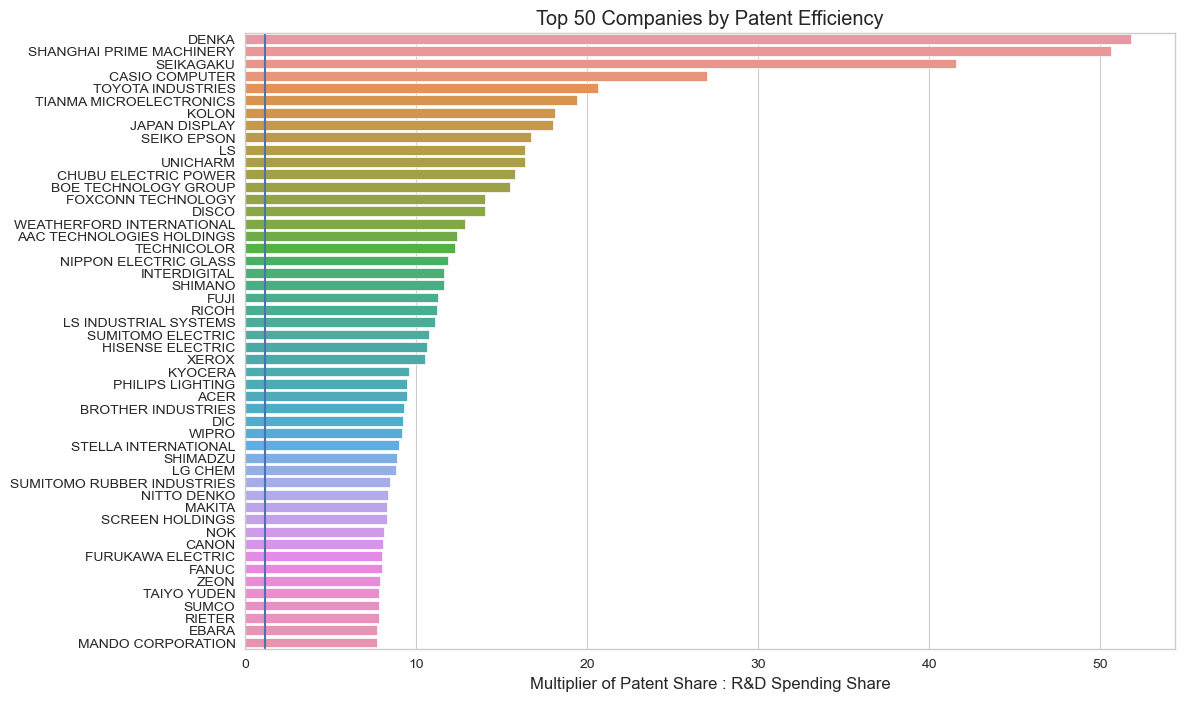

In [407]:
# Barplot of Top 50 by Patent Efficiency Metric

plt.figure(figsize=(12,8))
sns.barplot(y = 'company',
            x = 'patent_eff',
            data = ordered_df
           )

# Axes and Labels
plt.yticks(fontsize = 10)
plt.title('Top 50 Companies by Patent Efficiency')
plt.ylabel('')
plt.xlabel('Multiplier of Patent Share : R&D Spending Share')

# Draw a line at the average multiplier value
plt.axvline(x = company_analysis['patent_eff'].mean())

# Show graph
plt.show()


### Question: How does FANGMAN (Facebook, Amazon, Netflix, Google, Microsoft, Apple, Nvidia) rank on R&D activity?

In [453]:
# Create list of FANGMAN companies
fangman = ['FACEBOOK',
           'AMAZON',
           'NETFLIX',
           'ALPHABET',
           'MICROSOFT',
           'APPLE',
           'NVIDIA']
           
# Find observations in dataset that match
df = company_analysis
df_fangman = df.loc[df['company'].isin(fangman)]
df_fangman


,rank,company,hq_country,industry,rd_share,patent_share,trademark_share,patent_eff,rank_rd_share,rank_patent_share,rank_patent_eff
0,1,ALPHABET,United States,IT services,2.269,0.553,0.431,0.243720,1.0,35.0,1040.0
2,3,MICROSOFT,United States,Publishing & broadcasting,1.831,0.358,0.243,0.195522,3.0,63.0,1103.0
5,6,APPLE,United States,Computers & electronics,1.544,0.302,0.370,0.195596,6.0,75.0,1102.0
10,11,FACEBOOK,United States,IT services,1.114,0.082,0.164,0.073609,11.0,246.5,1340.0
66,67,NVIDIA,United States,Computers & electronics,0.258,0.036,0.108,0.139535,67.0,428.0,1195.0
141,142,NETFLIX,United States,Admin & support services,0.132,0.008,0.174,0.060606,143.5,855.0,1368.0


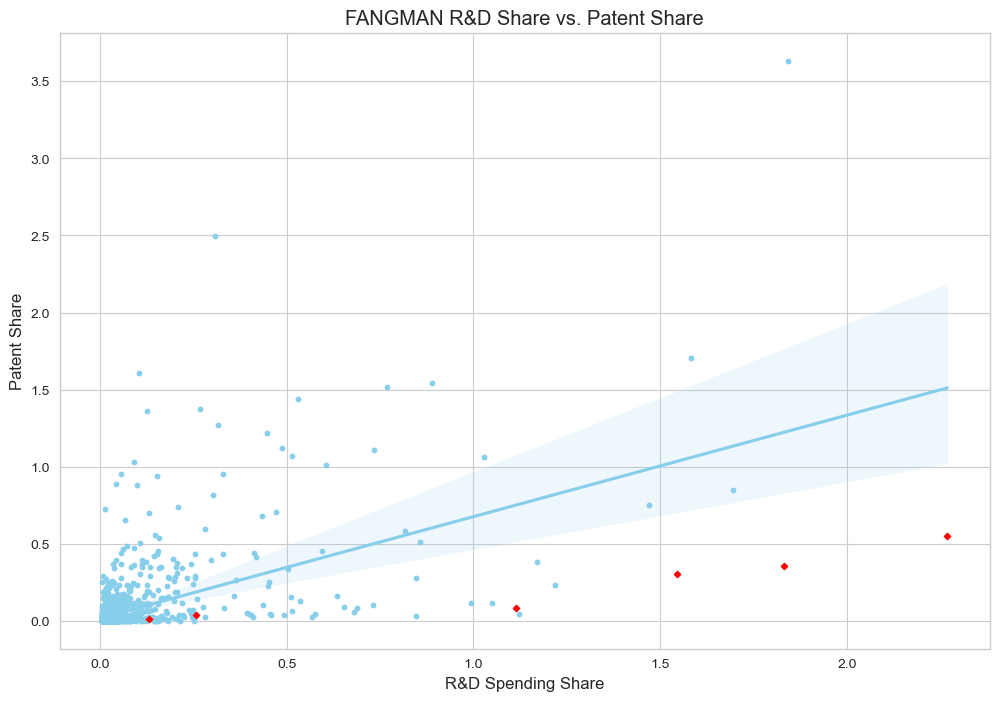

In [464]:
# Scatterplot with Linear Regression

# Draw scatterplot
df = company_analysis

plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
sns.regplot(x = 'rd_share', 
            y = 'patent_share',
            data = df,
            x_jitter = 0.0,
            y_jitter = 0.0,
            scatter_kws = {"color":"skyblue", "alpha":1, "s":10},
            line_kws = {"color":"skyblue"},
           )

sns.regplot(x = 'rd_share',
            y = 'patent_share',
            data = df_fangman,
            fit_reg = False,
            marker = "D",
            scatter_kws = {"color":"red", "alpha":1, "s":10}
           )


# Axes and Labels
plt.title('FANGMAN R&D Share vs. Patent Share')
plt.xlabel('R&D Spending Share')
plt.ylabel('Patent Share')

# Show graph
plt.show()

### Question: Who are the leading and lagging companies for R&D activity within each industry?

In [423]:
# Patent share leaders and laggards by industry

ind_co_1 = pd.DataFrame().assign(company=company_analysis['company'], 
                               industry=company_analysis['industry'],
                               rank_patent_share=company_analysis['rank_patent_share']
                              )

ind_co_1 = ind_co_1.sort_values(["rank_patent_share"], ascending=True).groupby("industry")

for key, values in ind_co_1:
    print(key)
    print("-"*70)
    print(values)
    print("\n")

Admin & support services
----------------------------------------------------------------------
                        company                  industry  rank_patent_share
1536               INTERDIGITAL  Admin & support services              219.0
1853                   ALLEGION  Admin & support services              820.0
141                     NETFLIX  Admin & support services              855.0
200                     SERVIER  Admin & support services             1042.0
1784                KYMAB GROUP  Admin & support services             1115.5
1587                      SECOM  Admin & support services             1351.0
780                        EYGS  Admin & support services             1351.0
819                    EXPERIAN  Admin & support services             1714.5
753    TONGCHENG-ELONG HOLDINGS  Admin & support services             1714.5
440   ZHEJIANG DAHUA TECHNOLOGY  Admin & support services             1714.5
125     CTRIP.COM INTERNATIONAL  Admin & support services

In [424]:
# Patent efficiency leaders and laggards by industry

ind_co_2 = pd.DataFrame().assign(company=company_analysis['company'], 
                               industry=company_analysis['industry'],
                               rank_patent_eff=company_analysis['rank_patent_eff']
                              )

ind_co_2 = ind_co_2.sort_values(["rank_patent_eff"], ascending=True).groupby("industry")

for key, values in ind_co_2:
    print(key)
    print("-"*70)
    print(values)
    print("\n")

Admin & support services
----------------------------------------------------------------------
                        company                  industry  rank_patent_eff
1536               INTERDIGITAL  Admin & support services             20.0
1853                   ALLEGION  Admin & support services            445.0
1784                KYMAB GROUP  Admin & support services            825.5
1587                      SECOM  Admin & support services           1181.5
141                     NETFLIX  Admin & support services           1368.0
780                        EYGS  Admin & support services           1376.0
200                     SERVIER  Admin & support services           1395.0
440   ZHEJIANG DAHUA TECHNOLOGY  Admin & support services           1714.5
1897   BEIJING ORIENT LANDSCAPE  Admin & support services           1714.5
1890                 EVENTBRITE  Admin & support services           1714.5
125     CTRIP.COM INTERNATIONAL  Admin & support services           1714.5
1334